In [1]:
import jax.numpy as jnp
import numpy as np
import os
from jax import jit
from functools import partial
import matplotlib.pyplot as plt

import appletree as apt
from appletree import flex
from appletree import ipm
from appletree import imm
from appletree.flex import randgen
from appletree.flex.plugin import *

In [2]:
apt.utils.set_gpu_memory_usage(0.2)
par_manager = ipm.ParManager()
map_manager = imm.MapManager()

In [3]:
map_manager.register_json_map(os.path.join(imm.DATAPATH, 's1_correction_map_regbin.json'), coord_type='regbin', map_name='s1_lce')
map_manager.register_json_map(os.path.join(imm.DATAPATH, 's2_correction_map_regbin.json'), coord_type='regbin', map_name='s2_lce')
map_manager.register_json_map(os.path.join(imm.DATAPATH, 'elife.json'), coord_type='point', map_name='elife')
map_manager.register_json_map(os.path.join(imm.DATAPATH, 's1_bias.json'), coord_type='point', map_name='s1_bias')
map_manager.register_json_map(os.path.join(imm.DATAPATH, 's1_smearing.json'), coord_type='point', map_name='s1_smear')
map_manager.register_json_map(os.path.join(imm.DATAPATH, 's2_bias.json'), coord_type='point', map_name='s2_bias')
map_manager.register_json_map(os.path.join(imm.DATAPATH, 's2_smearing.json'), coord_type='point', map_name='s2_smear')
map_manager.register_json_map(os.path.join(imm.DATAPATH, '3fold_recon_eff.json'), coord_type='point', map_name='s1_3fold_eff')

In [6]:
map_manager.get_registration()

{'s1_lce': '/home/zihaoxu/appletree/appletree/imm/data/s1_correction_map_regbin.json',
 's2_lce': '/home/zihaoxu/appletree/appletree/imm/data/s2_correction_map_regbin.json',
 'elife': '/home/zihaoxu/appletree/appletree/imm/data/elife.json',
 's1_bias': '/home/zihaoxu/appletree/appletree/imm/data/s1_bias.json',
 's1_smear': '/home/zihaoxu/appletree/appletree/imm/data/s1_smearing.json',
 's2_bias': '/home/zihaoxu/appletree/appletree/imm/data/s2_bias.json',
 's2_smear': '/home/zihaoxu/appletree/appletree/imm/data/s2_smearing.json',
 's1_3fold_eff': '/home/zihaoxu/appletree/appletree/imm/data/3fold_recon_eff.json'}

#### Microphysics plugins

In [4]:
plugin1 = EnergySpectra(par_manager, 0.01, 20.)
plugin2 = Quenching(par_manager)
plugin3 = Ionization(par_manager)
plugin4 = mTI(par_manager)
plugin5 = RecombFluct(par_manager)
plugin6 = TrueRecomb(par_manager)
plugin7 = Recombination(par_manager)

#### Detector plugins

In [7]:
plugin8 = PositionSpectra(par_manager)
plugin9 = S1Correction(par_manager, map_manager.get_map('s1_lce'))
plugin10 = S2Correction(par_manager, map_manager.get_map('s2_lce'))
plugin11 = PhotonDetection(par_manager)
plugin12 = S1PE(par_manager)
plugin13 = DriftLoss(par_manager, map_manager.get_map('elife'))
plugin14 = ElectronDrifted(par_manager)
plugin15 = S2PE(par_manager)

#### Reconstruction plugins

In [8]:
plugin16 = S1(par_manager, map_manager.get_map('s1_bias'), map_manager.get_map('s1_smear'))
plugin17 = S2(par_manager, map_manager.get_map('s2_bias'), map_manager.get_map('s2_smear'))
plugin18 = cS1(par_manager)
plugin19 = cS2(par_manager)

#### Efficiency plugins

In [9]:
plugin20 = S2Threshold(par_manager)
plugin21 = S1ReconEff(par_manager, map_manager.get_map('s1_3fold_eff'))

# Pipeline

In [10]:
@apt.utils.timeit
@partial(jit, static_argnums=(1, ))
def sim(key, n):
    key, energy = plugin1(key, n)
    key, n_q = plugin2(key, energy)
    key, n_i = plugin3(key, n_q)
    key, r_mean = plugin4(key, energy)
    key, r_std = plugin5(key, energy)
    key, r = plugin6(key, r_mean, r_std)
    key, n_ph, n_e = plugin7(key, n_q, n_i, r)
    
    key, x, y, z = plugin8(key, n)
    key, s1_correction = plugin9(key, x, y, z)
    key, s2_correction = plugin10(key, x, y)
    key, n_s1_phd = plugin11(key, n_ph, s1_correction)
    key, n_s1_pe = plugin12(key, n_s1_phd)
    key, surv_prob = plugin13(key, z)
    key, n_e_drifted = plugin14(key, n_e, surv_prob)
    key, n_s2_pe = plugin15(key, n_e_drifted, s2_correction)
    
    key, s1 = plugin16(key, n_s1_phd, n_s1_pe)
    key, s2 = plugin17(key, n_s2_pe)
    key, cs1 = plugin18(key, s1, s1_correction)
    key, cs2 = plugin19(key, s2, s2_correction, surv_prob)
    
    key, acc_s2_threshold = plugin20(key, s2)
    key, acc_s1_recon_eff = plugin21(key, n_s1_phd)
    
    eff = acc_s2_threshold*acc_s1_recon_eff
    
    hist, be = jnp.histogramdd(
        jnp.asarray([cs1, cs2]).T,
        bins=(jnp.linspace(0,100,101), jnp.logspace(2.5,4.1,81)),
        weights=eff
    )
    
    return key, hist, be

In [11]:
batch_size = int(1e6)
key = flex.randgen.get_key()

#### Build

In [12]:
key, hist, be = sim(key, batch_size)

 Function <sim> starts. 
 Function <sim> ends! Time cost = 5151.892185 msec. 


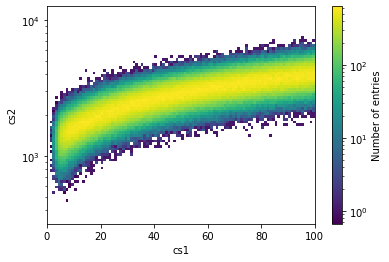

In [13]:
import numpy as np
import multihist as mh
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

hist = mh.Histdd.from_histogram(
    np.array(hist), 
    be, 
    axis_names=['cs1', 'cs2']
)
hist.plot(norm=LogNorm())
plt.yscale('log')
plt.show()

#### Speed test

In [14]:
@apt.utils.timeit
def benchmark():
    key = randgen.get_key()
    for itr in range(100):
        key, _, _ = sim(key, int(1e6))

In [15]:
benchmark()

 Function <benchmark> starts. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 4.128218 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 3.060818 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 5.967379 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 17.715693 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 17.577887 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 13.336420 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 15.454531 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 19.866228 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 17.364264 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 15.374422 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 15.302181 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 13.527393 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 1